# Classification And Regression Trees

In [1]:
import numpy as np

This jupyter notebook is inspired by [the blog post "How To Implement The Decision Tree Algorithm From Scratch In Python"](https://machinelearningmastery.com/implement-decision-tree-algorithm-scratch-python/).

We define a decision tree which is recursively enlarged until a termination criterion (depth or minimum number of elements in the leaves) is met.
We construct each node in the tree to be a dictionary containing:
* the index of the feature to be considered in the split
* the value to compare to in the split
* the groups of training examples falling to the left or right of the comparison
* left and right nodes (with same structure as above)

For predicting the root node is visited, the feature index and value to compare to are found. Then the left or right child node is chosen comparing the input feature vector entry to the value. Like this the tree is traversed till hitting a leaf node.

In [2]:
# Select the best split point for a dataset
def get_best_split(x_train, y_train, instance_indices):
    # decide on splits via exhaustive search
    split_scores = []
    groups = []
    means = []
    num_features = x_train.shape[1]
    for feature_i in range(num_features):
        mean_i = np.mean(x_train[instance_indices, feature_i])
        mask_samples_smaller_than_mean = x_train[instance_indices, feature_i] < mean_i
        mask_samples_bigger_than_mean = x_train[instance_indices, feature_i] > mean_i
        # split score is higher if it is separating the classes better
        split_score = np.abs(
            np.sum(y_train[instance_indices][mask_samples_bigger_than_mean])
            - np.sum(y_train[instance_indices][mask_samples_smaller_than_mean])
        )
        split_scores.append(split_score)
        groups.append(
            {
                "left": instance_indices[mask_samples_smaller_than_mean],
                "right": instance_indices[mask_samples_bigger_than_mean],
            }
        )
        means.append(mean_i)
    split_scores = np.array(split_scores)
    # greedily choose the feature which separetes the classes best, based on the sample mean of the feature
    best_split_feature_index = np.argmax(split_scores)
    best_groups = groups[best_split_feature_index]
    best_value = means[best_split_feature_index]
    return {
        "index": best_split_feature_index,
        "value": best_value,
        "groups": best_groups,
    }


def recursive_split(node, x_train, y_train, max_depth, min_size, current_depth):
    if not "left" in node:
        best_split_left = get_best_split(x_train, y_train, node["groups"]["left"])
        current_depth += 1
        if current_depth < max_depth + 1 and len(node["groups"]["left"]) > min_size:
            node["left"] = best_split_left
            recursive_split(
                best_split_left, x_train, y_train, max_depth, min_size, current_depth
            )
        else:
            # do not split further
            sum_y_train_below_split = np.sum(y_train[best_split_left["groups"]["left"]])
            sum_y_train_above_split = np.sum(
                y_train[best_split_left["groups"]["right"]]
            )
            # determine the leaf value based on the majority
            node["left"] = (
                0
                if sum_y_train_below_split + sum_y_train_above_split
                < (
                    len(best_split_left["groups"]["left"])
                    + len(best_split_left["groups"]["right"])
                )
                // 2
                else 1
            )
    if not "right" in node:
        best_split_right = get_best_split(x_train, y_train, node["groups"]["right"])
        current_depth += 1
        if current_depth < max_depth + 1 and len(node["groups"]["right"]) > min_size:
            node["right"] = best_split_right
            recursive_split(
                best_split_right, x_train, y_train, max_depth, min_size, current_depth
            )
        else:
            # do not split further
            sum_y_train_below_split = np.sum(
                y_train[best_split_right["groups"]["left"]]
            )
            sum_y_train_above_split = np.sum(
                y_train[best_split_right["groups"]["right"]]
            )
            node["right"] = (
                0
                if sum_y_train_below_split + sum_y_train_above_split
                < (
                    len(best_split_right["groups"]["left"])
                    + len(best_split_right["groups"]["right"])
                )
                // 2
                else 1
            )
    return node


def build_tree(train_set, max_depth, min_size):
    num_features = train_set.shape[1] - 1
    num_samples = train_set.shape[0]
    x_train = train_set[:, :num_features]
    y_train = train_set[:, num_features]
    instance_indices = np.array(range(num_samples))
    tree = get_best_split(x_train, y_train, instance_indices)
    current_depth = 0
    recursive_split(tree, x_train, y_train, max_depth, min_size, current_depth)
    return tree


def predict(node, feature_vector):
    # recursively go through the tree and find the leaf node which applies
    if feature_vector[node["index"]] < node["value"]:
        if isinstance(node["left"], dict):
            return predict(node["left"], feature_vector)
        else:
            # terminal node
            return node["left"]
    else:
        if isinstance(node["right"], dict):
            return predict(node["right"], feature_vector)
        else:
            # terminal node
            return node["right"]

Train the decision tree on the training set and apply it on the test set.

In [ ]:
# generate test and train set
loc_a = 1
loc_b = -1.0
num_samples = 1000


def generate_data(inner_radius, outer_radius, target):
    random_nrs = np.random.normal(
        loc=0.0, scale=outer_radius, size=(50 * num_samples, 2)
    )
    radii = np.sqrt(np.sum(random_nrs ** 2, axis=1))
    mask_circle = np.logical_and(radii > inner_radius, radii < outer_radius)
    if np.sum(mask_circle) < num_samples:
        raise RuntimError("sample data could not be generated")
    random_nrs = random_nrs[mask_circle][:num_samples]
    return np.concatenate(
        (random_nrs, target * np.ones(shape=(num_samples, 1))), axis=1
    )


train_set = generate_data(inner_radius=0, outer_radius=2, target=0)
train_set = np.concatenate(
    (train_set, generate_data(inner_radius=3, outer_radius=4, target=1)), axis=0
)
test_set = generate_data(inner_radius=0, outer_radius=2, target=0)
test_set = np.concatenate(
    (train_set, generate_data(inner_radius=3, outer_radius=4, target=1)), axis=0
)


# simpler sets, just multivariate gaussians
# train_set=np.concatenate((np.concatenate((np.random.normal(loc=(loc_a, loc_a), scale=1, size=(num_samples,2)), np.ones(shape=(num_samples,1))), axis=1), np.concatenate((np.random.normal(loc=(loc_b, loc_b), scale=1, size=(num_samples,2)), np.zeros(shape=(num_samples,1))), axis=1)), axis=0)
# test_set=np.concatenate((np.concatenate((np.random.normal(loc=(loc_a, loc_a), scale=1, size=(num_samples,2)), np.ones(shape=(num_samples,1))), axis=1), np.concatenate((np.random.normal(loc=(loc_b, loc_b), scale=1, size=(num_samples,2)), np.zeros(shape=(num_samples,1))), axis=1)), axis=0)

# inplace shuffle
np.random.shuffle(test_set)
np.random.shuffle(train_set)

In [3]:
def decision_tree(train_set, test_set, max_depth=15, min_size=3):
    tree = build_tree(train_set, max_depth, min_size)
    predictions = []
    num_features = test_set.shape[1] - 1
    x_test = test_set[:, :num_features]
    y_test = test_set[:, num_features]
    assert np.all(np.logical_or(y_test == 0, y_test == 1))
    for feature_vector, target in zip(x_test, y_test):
        prediction = predict(tree, feature_vector)
        predictions.append(prediction)
    return predictions, y_test

In [4]:
predictions, y_test = decision_tree(train_set, test_set)

In [5]:
from sklearn.metrics import confusion_matrix

num_features = test_set.shape[1] - 1
tn, fp, fn, tp = confusion_matrix(y_test, predictions, normalize="true").ravel()
print(tn, fp, fn, tp)

0.959 0.041 0.006 0.994


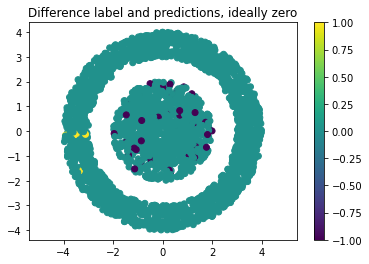

In [6]:
import matplotlib.pyplot as plt

plt.scatter(test_set[:, 0], test_set[:, 1], c=test_set[:, 2] - predictions)
plt.title("Difference label and predictions, ideally zero")
plt.axis("equal")
plt.colorbar()

Text(0.5, 1.0, 'original labels')

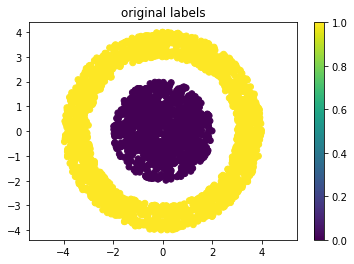

In [9]:
plt.scatter(test_set[:, 0], test_set[:, 1], c=test_set[:, 2])
plt.colorbar()
plt.axis("equal")
plt.title("original labels")

Text(0.5, 1.0, 'predicted labels')

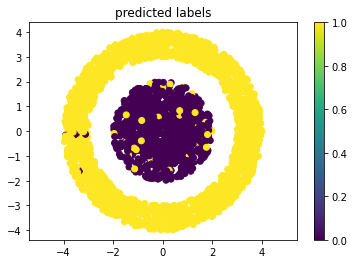

In [10]:
plt.scatter(test_set[:, 0], test_set[:, 1], c=predictions)
plt.colorbar()
plt.axis("equal")
plt.title("predicted labels")